# Preprocessing the Grocery dataset

In [205]:
data_path = 'coco_annotations/'
coco_train_file = data_path + 'coco_train_v300.json'
coco_val_file = data_path + 'coco_val_v300.json'

# Read the json files
import json
with open(coco_train_file) as f:
    coco_train = json.load(f)
with open(coco_val_file) as f:
    coco_val = json.load(f)

## Merge COCO files

In [203]:
import json

# merge two coco annotation files
coco1_train_file_path = 'coco_annotations/coco_train_v100.json'
coco1_val_file_path = 'coco_annotations/coco_val_v100.json'
coco2_train_file_path = 'coco_annotations/instances_train_v3.json'
coco2_val_file_path = 'coco_annotations/instances_val_v3.json'

with open(coco1_train_file_path) as f:
    coco1_train = json.load(f)
with open(coco1_val_file_path) as f:
    coco1_val = json.load(f)
with open(coco2_train_file_path) as f:
    coco2_train = json.load(f)
with open(coco2_val_file_path) as f:
    coco2_val = json.load(f)

# Adjust category IDs in coco2
for category in coco2_train['categories']:
    category['id'] -= 1
for category in coco2_val['categories']:
    category['id'] -= 1

# Adjust the category IDs in the annotations
for ann in coco2_train['annotations']:
    ann['category_id'] -= 1
for ann in coco2_val['annotations']:
    ann['category_id'] -= 1


# Adjust image IDs in coco2 to match filename
new_image_id_dict_train = {}
new_image_id_dict_val = {}

for image in coco2_train['images']:
    new_image_id_dict_train[image['id']] = int(image['file_name'].split('.')[0])
    image['id'] = int(image['file_name'].split('.')[0])

for image in coco2_val['images']:
    new_image_id_dict_val[image['id']] = int(image['file_name'].split('.')[0])
    image['id'] = int(image['file_name'].split('.')[0])

# Adjust the image IDs in the annotations
for ann in coco2_train['annotations']:
    ann['image_id'] = new_image_id_dict_train[ann['image_id']]
for ann in coco2_val['annotations']:
    ann['image_id'] = new_image_id_dict_val[ann['image_id']]


# Add images and annotations from coco2 to coco1
coco1_train['images'].extend(coco2_train['images'])
coco1_train['annotations'].extend(coco2_train['annotations'])

coco1_val['images'].extend(coco2_val['images'])
coco1_val['annotations'].extend(coco2_val['annotations'])



# Save the updated coco1 dictionary to a JSON file
merged_train_file = 'coco_annotations/coco_train_v300.json'
merged_val_file = 'coco_annotations/coco_val_v300.json'

with open(merged_train_file, 'w') as f:
    json.dump(coco1_train, f)

with open(merged_val_file, 'w') as f:
    json.dump(coco1_val, f)

## Check Rotated Images
We need to rotate portrait orientations because Coco Annotator automatically saves annotations in landscape orientation.

In [244]:
# Check portrait files
import os
import cv2

image_dir = 'datasets/grocery/images/val/'

# load images in dir
images = os.listdir(image_dir)
portrait_images_train = []
portrait_cats_train = []

for image in images:
    if image[:2] == '09':
        id = int(image.split('.')[0][2:])
        if id > 350:
            img = cv2.imread(os.path.join(image_dir, image))
            if img.shape[0] > img.shape[1]:
                # rotate image
                rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                # save image
                cv2.imwrite(os.path.join(image_dir, image), rotated_img)


## Visualize images and annotations

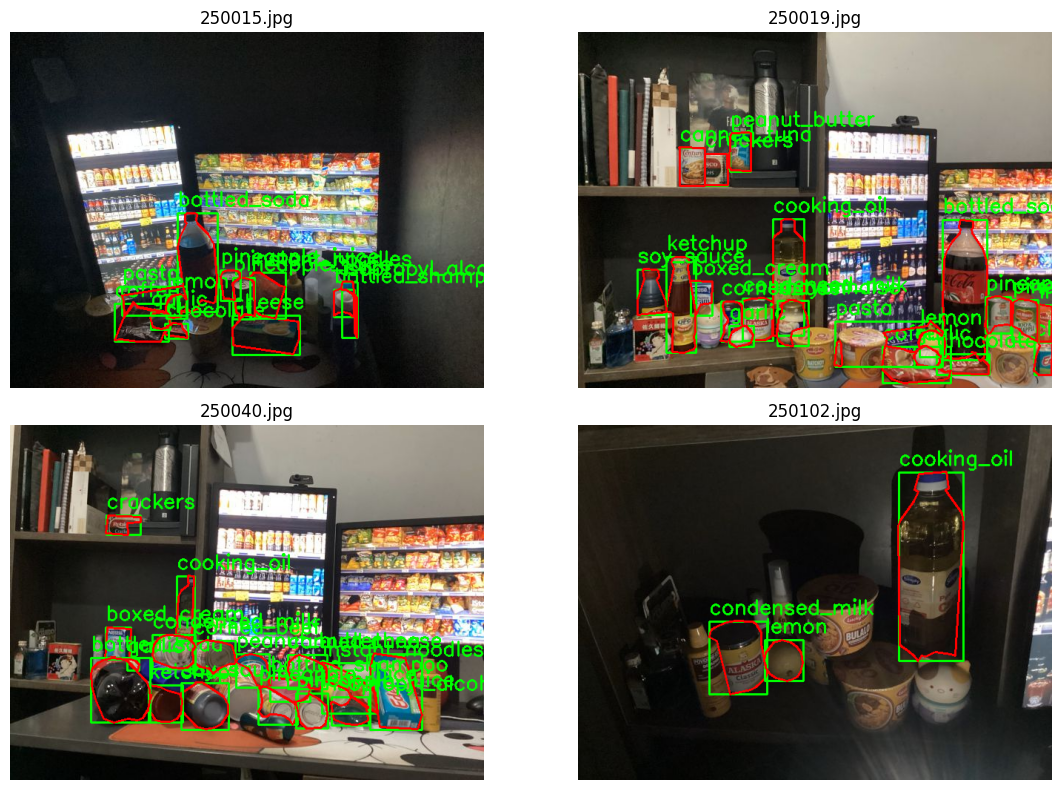

In [207]:
import cv2
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np

train = False

if train:
    image_path = 'datasets/grocery/images/train'
    coco_data = coco_train
else:
    image_path = 'datasets/grocery/images/val'
    coco_data = coco_val

# Create a dictionary to map image IDs to file names for easy access
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Create a dictionary to map category IDs to class names
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Randomly select 4 images
# selected_images = random.sample(coco_data['images'], 4)

# Filter images by the specified image IDs
selected_image_ids = [250102,250040,250019,250015]
selected_images = [img for img in coco_data['images'] if img['id'] in selected_image_ids]

# Define function to draw bounding boxes, segmentation, and class names
def draw_annotations(image, annotation):
    # Draw bounding box
    bbox = annotation['bbox']
    x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
    
    # Draw segmentation mask
    if 'segmentation' in annotation:
        for segment in annotation['segmentation']:
            points = [(int(segment[i]), int(segment[i + 1])) for i in range(0, len(segment), 2)]
            points = np.array(points, dtype=np.int32)
            cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)  # Red line
    
    # Draw class name
    class_name = category_id_to_name[annotation['category_id']]
    cv2.putText(image, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)  # Green text
    
    return image

# Plot images with annotations
plt.figure(figsize=(12, 8))

for i, img_info in enumerate(selected_images):
    # Load image
    img_path = os.path.join(image_path, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get annotations for this image
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_info['id']]
    
    # Draw each annotation on the image
    for annotation in annotations:
        image = draw_annotations(image, annotation)
    
    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(img_info['file_name'])

plt.tight_layout()
plt.show()

## Get Validation set from training data

In [ ]:
# import os
# import shutil
# import random
# import json

# # Paths to image directories
# image_path_train = 'dataset/images/train'
# image_path_val = 'dataset/images/val'

# # Create directories for new training and validation images
# new_image_path_train = 'dataset/images/new_train'
# new_image_path_val = 'dataset/images/new_val'
# os.makedirs(new_image_path_train, exist_ok=True)
# os.makedirs(new_image_path_val, exist_ok=True)

# # Split the training data to create a new validation set
# random.shuffle(coco_train['images'])
# split_index = int(0.8 * len(coco_train['images']))
# new_train_images = coco_train['images'][:split_index]
# new_val_images = coco_train['images'][split_index:]

# # Create new training and validation datasets
# new_coco_train = {
#     'images': new_train_images,
#     'annotations': [ann for ann in coco_train['annotations'] if ann['image_id'] in {img['id'] for img in new_train_images}],
#     'categories': coco_train['categories']
# }

# new_coco_val = {
#     'images': new_val_images,
#     'annotations': [ann for ann in coco_train['annotations'] if ann['image_id'] in {img['id'] for img in new_val_images}],
#     'categories': coco_train['categories']
# }

# # Use the original validation set as the test set
# new_coco_test = coco_val

# # Move images to new directories based on the split
# for img in new_train_images:
#     src_path = os.path.join(image_path_train, img['file_name'])
#     dst_path = os.path.join(new_image_path_train, img['file_name'])
#     shutil.move(src_path, dst_path)

# for img in new_val_images:
#     src_path = os.path.join(image_path_train, img['file_name'])
#     dst_path = os.path.join(new_image_path_val, img['file_name'])
#     shutil.move(src_path, dst_path)

# # Save the new splits to JSON files
# data_path = 'dataset/annotations/'
# with open(os.path.join(data_path, 'new_instances_train.json'), 'w') as f:
#     json.dump(new_coco_train, f)
# with open(os.path.join(data_path, 'new_instances_val.json'), 'w') as f:
#     json.dump(new_coco_val, f)
# with open(os.path.join(data_path, 'new_instances_test.json'), 'w') as f:
#     json.dump(new_coco_test, f)

## Convert Coco to YOLO format


In [177]:
coco_train_file = 'coco_annotations/coco_train_v300.json'
coco_val_file = 'coco_annotations/coco_val_v300.json'

# Read the json files
import json
with open(coco_train_file) as f:
    coco_train = json.load(f)
with open(coco_val_file) as f:
    coco_val = json.load(f)

In [208]:
import os
import json
import numpy as np

# Define function to clip and normalize segmentation points
def clip_and_normalize_segmentation_points(segmentation, img_width, img_height):
    clipped_normalized_segmentation = []
    for segment in segmentation:
        clipped_normalized_segment = []
        for i in range(0, len(segment), 2):
            x = max(0, min(img_width, segment[i])) / img_width
            y = max(0, min(img_height, segment[i + 1])) / img_height
            clipped_normalized_segment.extend([x, y])
        clipped_normalized_segmentation.append(clipped_normalized_segment)
    return clipped_normalized_segmentation

# Define function to save annotations in YOLO format with clipped and normalized segmentation points
def save_annotations_yolo(coco_data, image_id_to_filename, output_dir):
    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store annotations for each image
    annotations_dict = {}
    
    for annotation in coco_data['annotations']:
        try:
            # Get image file name
            image_id = annotation['image_id']
            image_filename = image_id_to_filename[image_id]
            label_filename = os.path.splitext(image_filename)[0] + '.txt'
            
            # Get image width and height
            image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
            img_width = image_info['width']
            img_height = image_info['height']
            
            # Get category ID and custom class ID
            category_id = annotation['category_id']
            
            # Extract, clip, and normalize segmentation points
            if 'segmentation' in annotation:
                segmentation = annotation['segmentation']
                clipped_normalized_segmentation = clip_and_normalize_segmentation_points(segmentation, img_width, img_height)
                # Flatten the segmentation points and convert to string
                segmentation_str = ' '.join(map(str, [point for segment in clipped_normalized_segmentation for point in segment]))
                
                # Prepare annotation line
                line = f"{category_id} {segmentation_str}\n"
                
                # Append annotation to the corresponding image's label file
                if label_filename not in annotations_dict:
                    annotations_dict[label_filename] = []
                annotations_dict[label_filename].append(line)
        except KeyError as e:
            print(f"KeyError: {e} - Annotation: {annotation}")
        except IndexError as e:
            print(f"IndexError: {e} - Annotation: {annotation}")
    
    # Write annotations to separate files
    for label_filename, lines in annotations_dict.items():
        with open(os.path.join(output_dir, label_filename), 'w') as f:
            f.writelines(lines)

# Create a dictionary to map image IDs to file names for easy access
image_id_to_filename_train = {img['id']: img['file_name'] for img in coco_train['images']}
image_id_to_filename_val = {img['id']: img['file_name'] for img in coco_val['images']}


# Save annotations in YOLO format
save_annotations_yolo(coco_train, image_id_to_filename_train, 'datasets/grocery/labels/train')
save_annotations_yolo(coco_val, image_id_to_filename_val, 'datasets/grocery/labels/val')

In [209]:
# Count number of files in labels/train and labels/val
import os

train_dir = 'datasets/grocery/labels/train'
val_dir = 'datasets/grocery/labels/val'

train_files = os.listdir(train_dir)
val_files = os.listdir(val_dir)

print(f"Number of files in {train_dir}: {len(train_files)}")
print(f"Number of files in {val_dir}: {len(val_files)}")
print("Number of images in training set:",len(coco_train['images']))
print("Number of images in val set:",len(coco_val['images']))

Number of files in datasets/grocery/labels/train: 10058
Number of files in datasets/grocery/labels/val: 1119
Number of images in training set: 10064
Number of images in val set: 1119


## Preprocess annotations for peanut butter and canned_tuna

In [79]:
# Open new coco merged files
new_coco_train_file = r'coco_annotations/coco_merged_train.json'
new_coco_val_file = r'coco_annotations/coco_merged_val.json'

with open(new_coco_train_file) as f:
    coco_train = json.load(f)
with open(new_coco_val_file) as f:
    coco_val = json.load(f)

# Select annotations and images for class 13 and 22
class13_train_annotations = [ann for ann in coco_train['annotations'] if ann['category_id'] == 13]
class13_train_image_ids = {ann['image_id'] for ann in class13_train_annotations}

class13_val_annotations = [ann for ann in coco_val['annotations'] if ann['category_id'] == 13]
class13_val_image_ids = {ann['image_id'] for ann in class13_val_annotations}

class22_train_annotations = [ann for ann in coco_train['annotations'] if ann['category_id'] == 22]
class22_train_image_ids = {ann['image_id'] for ann in class22_train_annotations}

class22_val_annotations = [ann for ann in coco_val['annotations'] if ann['category_id'] == 22]
class22_val_image_ids = {ann['image_id'] for ann in class22_val_annotations}

In [81]:
# Count isbbox = True
isbbox = 0
for ann in class22_train_annotations:
    if ann['isbbox']:
        isbbox += 1
print(len(class22_train_annotations))
print(isbbox)

isbbox = 0
for ann in class13_train_annotations:
    if ann['isbbox']:
        isbbox += 1
print(len(class13_train_annotations))
print(isbbox)

1973
999
1790
898


In [82]:
# Function to filter annotations
def filter_annotations(coco_data, category_ids, isbbox=True):
    filtered_annotations = [
        ann for ann in coco_data['annotations']
        if not (ann['category_id'] in category_ids and ann.get('isbbox', False) == isbbox)
    ]
    coco_data['annotations'] = filtered_annotations
    return coco_data

# Define the category IDs to remove
category_ids_to_remove = [13, 22]

# Filter annotations in coco_train and coco_val
coco_train = filter_annotations(coco_train, category_ids_to_remove)
coco_val = filter_annotations(coco_val, category_ids_to_remove)

# Verify that the annotations have been removed
isbbox_train = sum(1 for ann in coco_train['annotations'] if ann['category_id'] in category_ids_to_remove and ann.get('isbbox', False))
isbbox_val = sum(1 for ann in coco_val['annotations'] if ann['category_id'] in category_ids_to_remove and ann.get('isbbox', False))

print(f"Remaining isbbox annotations in coco_train: {isbbox_train}")
print(f"Remaining isbbox annotations in coco_val: {isbbox_val}")

Remaining isbbox annotations in coco_train: 0
Remaining isbbox annotations in coco_val: 0


In [83]:
new_class22_train_annotations = [ann for ann in coco_train['annotations'] if ann['category_id'] == 22]
new_class13_train_annotations = [ann for ann in coco_train['annotations'] if ann['category_id'] == 13]

print(len(new_class22_train_annotations))
print(len(new_class13_train_annotations))

974
892


In [85]:
# Save the updated files
new_coco_train_file = r'coco_annotations/coco_merged_train_filtered.json'
new_coco_val_file = r'coco_annotations/coco_merged_val_filtered.json'

with open(new_coco_train_file, 'w') as f:
    json.dump(coco_train, f)
with open(new_coco_val_file, 'w') as f:
    json.dump(coco_val, f)

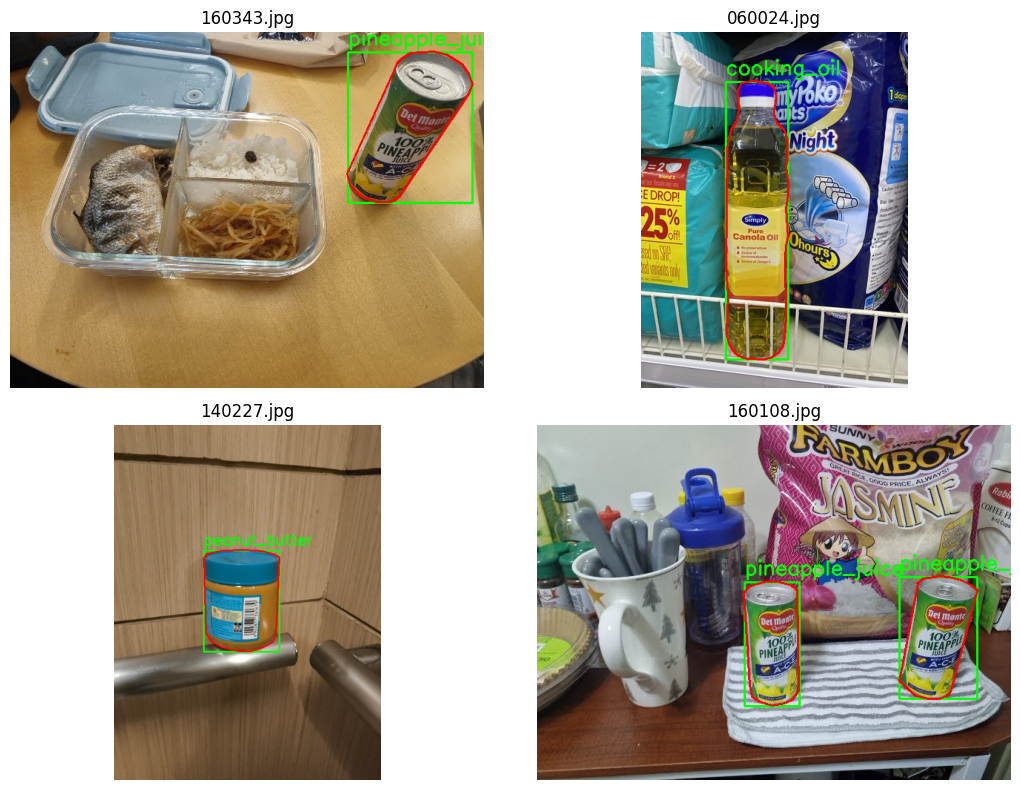

In [146]:
import cv2
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np



# Create a dictionary to map image IDs to file names for easy access
image_id_to_filename = {img['id']: img['file_name'] for img in coco_train['images']}

# Create a dictionary to map category IDs to class names
category_id_to_name = {cat['id']: cat['name'] for cat in coco_train['categories']}

# Randomly select 4 images
selected_images = random.sample(coco_train['images'], 4)


# Select images with class 22 annotations
# selected_images = random.sample([img for img in coco_train['images'] if img['id'] in class13_train_image_ids], 4)

# Filter images by the specified image IDs
# selected_image_ids = [5770,5771,5772,5773]
# selected_images = [img for img in coco_train['images'] if img['id'] in selected_image_ids]

# Define function to draw bounding boxes, segmentation, and class names
def draw_annotations(image, annotation):
    # Draw bounding box
    bbox = annotation['bbox']
    x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
    
    # Draw segmentation mask
    if 'segmentation' in annotation:
        for segment in annotation['segmentation']:
            points = [(int(segment[i]), int(segment[i + 1])) for i in range(0, len(segment), 2)]
            points = np.array(points, dtype=np.int32)
            cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)  # Red line
    
    # Draw class name
    class_name = category_id_to_name[annotation['category_id']]
    cv2.putText(image, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)  # Green text
    
    return image

# Plot images with annotations
plt.figure(figsize=(12, 8))

for i, img_info in enumerate(selected_images):
    # Load image
    img_path = os.path.join(image_path, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get annotations for this image
    annotations = [ann for ann in coco_train['annotations'] if ann['image_id'] == img_info['id']]
    
    # Draw each annotation on the image
    for annotation in annotations:
        image = draw_annotations(image, annotation)
    
    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(img_info['file_name'])

plt.tight_layout()
plt.show()

## Visualize new annotations

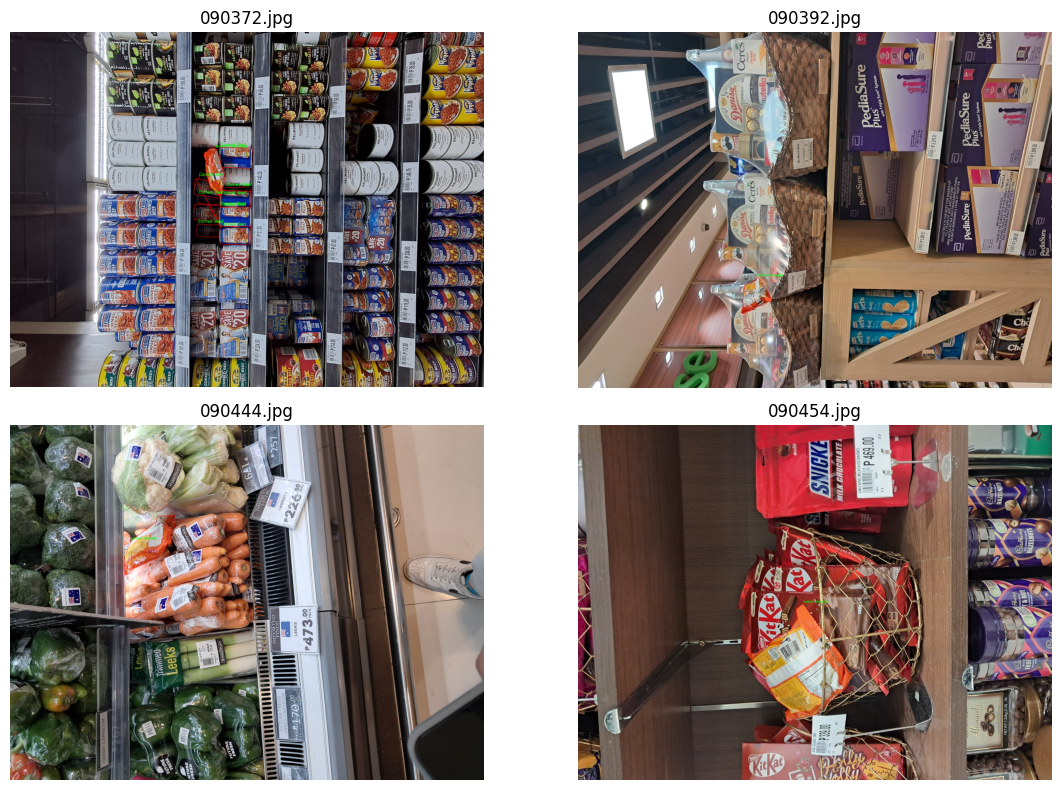

In [247]:
import cv2
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np

mode = 'val'  # Change to 'val' 
if mode == 'train':
    image_path = 'datasets/grocery/images/train'
    label_path = 'datasets/grocery/labels/train'
    coco_data = coco_train
elif mode == 'val':
    image_path = 'datasets/grocery/images/val'
    label_path = 'datasets/grocery/labels/val'
    coco_data = coco_val

# Create a dictionary to map image IDs to file names for easy access
image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Create a dictionary to map custom class IDs to category names
category_id_to_name = {
    0: 'Bottled Soda',
    1: 'Cheese',
    2: 'Chocolate',
    3: 'Instant Coffee',
    4: 'Condensed Milk',
    5: 'Cooking Oil',
    6: 'Corned Beef',
    7: 'Garlic',
    8: 'Instant Noodles',
    9: 'Ketchup',
    10: 'Lemon',
    11: 'All Purpose Cream',
    12: 'Mayonnaise',
    13: 'Peanut Butter',
    14: 'Pasta',
    15: 'Canned Juice',
    16: 'Crackers',
    17: 'Canned Sardines',
    18: 'Bottled Shampoo',
    19: 'Soap',
    20: 'Soy Sauce',
    21: 'Toothpaste',
    22: 'Canned Tuna',
    23: 'Ethyl Alcohol'
}

# Randomly sample 4 images
# selected_images = random.sample(coco_data['images'], 4)



# Filter images by the specified image IDs
selected_image_filenames = [90454, 90372, 90392, 90444]
selected_image_ids = [img_id for img_id, img_filename in image_id_to_filename.items() if int(img_filename.split('.')[0]) in selected_image_filenames]

selected_images = [img for img in coco_data['images'] if img['id'] in selected_image_ids]

# Filter by category/class ID
# class_number = 8
# selected_annotations = [ann for ann in coco_data['annotations'] if ann['category_id'] == class_number]
# selected_image_ids = {ann['image_id'] for ann in selected_annotations}
# selected_images = random.sample([img for img in coco_data['images'] if img['id'] in selected_image_ids], 4)

# Define function to draw segmentation and class names
def draw_annotations(image, label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        custom_class_id = int(parts[0])
        segmentation = list(map(float, parts[1:]))
        
        # Draw segmentation mask
        points = [(int(segmentation[i] * image.shape[1]), int(segmentation[i + 1] * image.shape[0])) for i in range(0, len(segmentation), 2)]
        points = np.array(points, dtype=np.int32)
        cv2.polylines(image, [points], isClosed=True, color=(255, 0, 0), thickness=2)  # Red line
        
        # Draw class name
        class_name = category_id_to_name[custom_class_id]
        x, y = points[0]
        cv2.putText(image, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)  # Green text
    
    return image

# Plot images with annotations
plt.figure(figsize=(12, 8))

for i, img_info in enumerate(selected_images):
    # Load image
    img_path = os.path.join(image_path, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get label file for this image
    label_filename = os.path.splitext(img_info['file_name'])[0] + '.txt'
    label_file = os.path.join(label_path, label_filename)
    
    # Draw annotations on the image
    image = draw_annotations(image, label_file)
    
    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(img_info['file_name'])

plt.tight_layout()
plt.show()